# Import and settings

In [1]:
%load_ext autoreload
%autoreload 2

import os, re, gc, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
import seaborn as sn
import plotnine as pln
import anndata
import scanpy as sc
import sctk as sk

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
expr_cmap = sk.expression_colormap()
np.set_printoptions(linewidth=150)

import numpy_groupies as npg
from sklearn.preprocessing import minmax_scale
from plotnine import ggplot, aes

/home/ubuntu/miniconda/envs/pyscenic/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.


In [2]:
import loompy as lp

In [3]:
import glob

# Load data

## h5ad

In [15]:
pooled_KC_obs = sc.read('../20200806_organoid_integration_comparison/h5ad/pooled_keratinocytes.processed.h5ad').obs

/home/ubuntu/miniconda/envs/pyscenic/lib/python3.8/site-packages/anndata/compat/__init__.py:158: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
/home/ubuntu/miniconda/envs/pyscenic/lib/python3.8/site-packages/anndata/compat/__init__.py:158: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.


In [16]:
pooled_MS_obs = sc.read('../20200806_organoid_integration_comparison/h5ad/pooled_mesenchymal.processed.h5ad').obs

In [14]:
fetal_ad = sc.read('../data/h5ad/fetal_skin.norm.maternal_removed.20210611.h5ad')

Only considering the two last: ['.20210611', '.h5ad'].
Only considering the two last: ['.20210611', '.h5ad'].


In [17]:
organoid_ad = sc.read('../20200427_organoid_integration/organoid.cellxgene.h5ad')

### Create pooled KC loom

In [18]:
fsk_KC_ad0 = fetal_ad[fetal_ad.obs_names.isin(pd.Series(pooled_KC_obs.index).str.replace('-fetal_skin', ''))].copy()

/home/ubuntu/miniconda/envs/pyscenic/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [19]:
org_KC_ad0 = organoid_ad[organoid_ad.obs_names.isin(pd.Series(pooled_KC_obs.index).str.replace('-organoid', ''))].copy()

In [20]:
fsk_KC_ad0

AnnData object with n_obs × n_vars = 1452 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation'
    var: 'gene_ids', 'mito', 'ribo', 'hb', 'n_cells', 'cc', 'n_counts'
    obsm: 'X_umap1', 'X_umap2'

In [21]:
org_KC_ad0

AnnData object with n_obs × n_vars = 2324 × 27320
    obs: 'sample_id', 'version', 'week', 'day', 'strain', 'batch', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'percent_top50', 'leiden_bk_split5', 'nh3_annot1', 'nh3_broad_annot1'
    var: 'gene_ids', 'gene_symbols', 'highly_variable'
    obsm: 'X_umap_hm', 'X_umap_bk'

In [22]:
pooled_KC_obs.shape

(3776, 27)

In [23]:
pooled_KC_ad = fsk_KC_ad0.concatenate(org_KC_ad0, join='outer', batch_key='dataset', batch_categories=['fetal_skin', 'organoid'])

/home/ubuntu/miniconda/envs/pyscenic/lib/python3.8/site-packages/anndata/_core/merge.py:891: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.


In [24]:
pooled_KC_ad.write('pooled_fsk_organoid_for_pyscenic.norm.h5ad', compression='lzf')

/home/ubuntu/miniconda/envs/pyscenic/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'sanger_id' as categorical
... storing 'chemistry' as categorical
... storing 'donor' as categorical
... storing 'gender' as categorical
... storing 'sorting' as categorical
... storing 'sample' as categorical
... storing 'chemistry_sorting' as categorical
... storing 'cell_caller' as categorical
... storing 'independent_annotation_refined' as categorical
... storing 'independent_annotation_broad1' as categorical
... storing 'independent_annotation_broad2' as categorical
... storing 'independent_annotation_broad3' as categorical
... storing 'independent_annotation_broad4' as categorical
... storing 'independent_annotation_broad5' as categorical
... storing 'joint_annotation' as categorical
... storing 'is_maternal' as categorical
... storing 'fig1b_annotation' as

In [107]:
pd.Series(np.isnan(pooled_KC_ad.obsm['X_umap_bk'][:, 0]), dtype='category').value_counts()

False    2324
True     1452
dtype: int64

In [18]:
pooled_KC_obs.columns

Index(['batch', 'chemistry_sorting', 'dataset', 'day', 'donor', 'gender',
       'n_counts', 'n_genes', 'nh3_annot1', 'percent_hb', 'percent_mito',
       'percent_ribo', 'percent_top50', 'rachel_annot3', 'sample_id',
       'sanger_id', 'strain', 'week', 'annot', 'leiden_hm_r0_1',
       'leiden_hm_r0_3', 'leiden_hm_r0_5', 'leiden_hm_r0_7', 'leiden_hm_r0_9',
       'annot1', 'joint_annot', 'leiden_hm_split1'],
      dtype='object')

In [19]:
pooled_KC_ad.obs = pooled_KC_obs.copy()

In [20]:
pooled_KC_ad0 = sk.restore_adata(pooled_KC_ad, restore_type='count', use_raw=False)

In [37]:
lp.create(
    'pooled_KC.count.loom', pooled_KC_ad0.X.transpose(),
    row_attrs={'Gene': pooled_KC_ad0.var_names.values},
    col_attrs={
        'CellID': pooled_KC_ad0.obs_names.values,
        'nGene': np.array((pooled_KC_ad0.X>0).sum(axis=1)).flatten(),
        'nUMI': np.array(pooled_KC_ad0.X.sum(axis=1)).flatten(),
        'joint_annot': pooled_KC_ad0.obs['joint_annot'].astype(str).values,
    }
)

### Create pooled MS loom

In [9]:
fsk_MS_ad0 = fetal_ad[fetal_ad.obs_names.isin(pd.Series(pooled_MS_obs.index).str.replace('-fetal_skin', ''))].copy()

/home/ubuntu/miniconda/envs/pyscenic/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [10]:
org_MS_ad0 = organoid_ad[organoid_ad.obs_names.isin(pd.Series(pooled_MS_obs.index).str.replace('-organoid', ''))].copy()

In [23]:
fsk_MS_ad0.n_obs + org_MS_ad0.n_obs

5895

In [24]:
pooled_MS_obs.shape

(6213, 24)

In [38]:
pooled_MS_ad = fsk_MS_ad0.concatenate(org_MS_ad0, join='outer', batch_key='dataset', batch_categories=['fetal_skin', 'organoid'])

/home/ubuntu/miniconda/envs/pyscenic/lib/python3.8/site-packages/anndata/_core/merge.py:891: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.


In [43]:
pooled_MS_ad.obs = pooled_MS_obs[pooled_MS_obs.index.isin(pooled_MS_ad.obs_names)].copy()

In [44]:
pooled_MS_ad0 = sk.restore_adata(pooled_MS_ad, restore_type='count', use_raw=False)

In [45]:
lp.create(
    'pooled_MS.count.loom', pooled_MS_ad0.X.transpose(),
    row_attrs={'Gene': pooled_MS_ad0.var_names.values},
    col_attrs={
        'CellID': pooled_MS_ad0.obs_names.values,
        'nGene': np.array((pooled_MS_ad0.X>0).sum(axis=1)).flatten(),
        'nUMI': np.array(pooled_MS_ad0.X.sum(axis=1)).flatten(),
        'joint_annot': pooled_MS_ad0.obs['joint_annot'].astype(str).values,
    }
)

### Clean up

In [11]:
del fetal_ad, organoid_ad

## other data

In [46]:
f_tfs = '../data/db/hs_hgnc_curated_tfs.txt'

In [55]:
f_db_glob = '../data/db/hg38__*.feather'
f_db_names = ' '.join(glob.glob(f_db_glob))
f_motif_path = '../data/db/motifs-v9-nr.hgnc-m0.001-o0.0.tbl'

In [56]:
f_db_names

'../data/db/hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr.feather ../data/db/hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.feather'

# Run GRN

In [48]:
!which pyscenic

/usr/local/bin/pyscenic


In [49]:
!/home/ubuntu/miniconda/envs/pyscenic/bin/pyscenic grn 'pooled_KC.count.loom' {f_tfs} -o pooled_KC.adj.csv --num_workers 5 


2021-11-29 12:07:23,952 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2021-11-29 12:07:26,264 - pyscenic.cli.pyscenic - INFO - Inferring regulatory networks.
preparing dask client
parsing input
creating dask graph
5 partitions
computing dask graph
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:37752 remote=tcp://127.0.0.1:41577>
not shutting down client, client was created externally
finished

2021-11-29 15:54:58,438 - pyscenic.cli.pyscenic - INFO - Writing results to file.


In [52]:
kc_adjacencies = pd.read_csv("pooled_KC.adj.csv", index_col=False)

In [53]:
kc_adjacencies.head()

,TF,target,importance
0,MXD3,CKS1B,142.708957
1,YBX1,EEF1B2,138.836137
2,YBX1,RPS3,134.684450
3,YBX1,RPS15,132.760201
4,ATF5,FTL,129.853957


In [57]:
!/home/ubuntu/miniconda/envs/pyscenic/bin/pyscenic ctx 'pooled_KC.adj.csv' \
    {f_db_names} \
    --annotations_fname {f_motif_path} \
    --expression_mtx_fname 'pooled_KC.count.loom' \
    --output pooled_KC.reg.csv \
    --mask_dropouts \
    --num_workers 5


2021-11-29 17:52:55,717 - pyscenic.cli.pyscenic - INFO - Creating modules.

2021-11-29 17:52:58,439 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2021-11-29 17:53:01,827 - pyscenic.utils - INFO - Calculating Pearson correlations.

2021-11-29 17:53:03,232 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [True].

2021-11-29 17:53:32,031 - pyscenic.utils - INFO - Creating modules.

2021-11-29 17:56:04,851 - pyscenic.cli.pyscenic - IN

In [68]:
nGenesDetectedPerCell = pd.DataFrame(np.sum(pooled_KC_ad0.X>0, axis=1))
percentiles = nGenesDetectedPerCell.quantile([.01, .05, .10, .50, 1])
print(percentiles)

           0
0.01   766.0
0.05  1085.0
0.10  1393.0
0.50  2621.5
1.00  7152.0


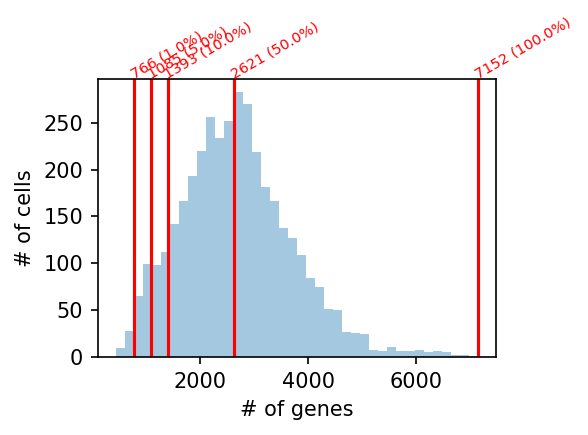

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150)
sn.distplot(nGenesDetectedPerCell, norm_hist=False, kde=False, bins='fd')
for i,x in enumerate(percentiles[0]):
    fig.gca().axvline(x=x, ymin=0,ymax=1, color='red')
    ax.text(x=x, y=ax.get_ylim()[1], s=f'{int(x)} ({percentiles.index.values[i]*100}%)', color='red', rotation=30, size='x-small',rotation_mode='anchor' )
ax.set_xlabel('# of genes')
ax.set_ylabel('# of cells')
fig.tight_layout()

In [74]:
!/home/ubuntu/miniconda/envs/pyscenic/bin/pyscenic aucell \
    'pooled_KC.count.loom' \
    'pooled_KC.reg.csv' \
    --output 'pooled_KC.pyscenic_output.loom' \
    --num_workers 5


2021-11-29 22:44:13,225 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2021-11-29 22:44:15,787 - pyscenic.cli.pyscenic - INFO - Loading gene signatures.
Create regulons from a dataframe of enriched features.
Additional columns saved: []

2021-11-29 22:45:14,555 - pyscenic.cli.pyscenic - INFO - Calculating cellular enrichment.

2021-11-29 22:45:35,791 - pyscenic.cli.pyscenic - INFO - Writing results to file.


# Further analysis

In [4]:
import json, zlib, base64

from pyscenic.rss import regulon_specificity_scores

from pyscenic.plotting import plot_rss
from adjustText import adjust_text

from pyscenic.binarization import binarize

import matplotlib as mpl
import seaborn as sns

In [5]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, 0.5 * size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center', fontsize=size * 10)
    return f

In [6]:
lf = lp.connect('pooled_KC.pyscenic_output.loom', mode='r+', validate=False)

In [7]:
pooled_KC_auc_mtx = pd.DataFrame(lf.ca.RegulonsAUC, index=lf.ca.CellID)

In [8]:
lf.close()

In [9]:
pooled_KC_ad = sc.read('pooled_fsk_organoid_for_pyscenic.norm.h5ad')

In [80]:
import umap

In [83]:
runUmap = umap.UMAP(n_neighbors=10, min_dist=0.4, metric='correlation').fit_transform
pooled_KC_dr_umap = runUmap(pooled_KC_auc_mtx)
pd.DataFrame(pooled_KC_dr_umap, columns=['X', 'Y'], index=pooled_KC_auc_mtx.index).to_csv( "pooled_KC.scenic_umap.txt", sep='\t')

In [91]:
lf = lp.connect('pooled_KC.pyscenic_output.loom', mode='r+', validate=False )
pooled_KC_meta = json.loads(zlib.decompress(base64.b64decode(lf.attrs.MetaData)))
pooled_KC_regulons = lf.ra.Regulons

In [87]:
pooled_KC_auc_mtx.columns = pooled_KC_auc_mtx.columns.str.replace('\(','_(')

In [92]:
pooled_KC_regulons.dtype.names = tuple([x.replace("(","_(") for x in pooled_KC_regulons.dtype.names])

In [93]:
pooled_KC_rt = pooled_KC_meta['regulonThresholds']
for i, x in enumerate(pooled_KC_rt):
    tmp = x.get('regulon').replace("(","_(")
    x.update( {'regulon': tmp} )

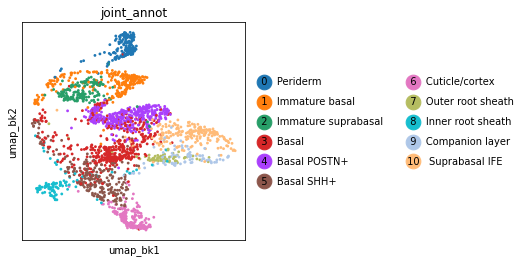

In [99]:
sk.plot_embedding(pooled_KC_ad, basis='umap_bk', groupby='joint_annot');

In [111]:
pooled_KC_ad.obsm['X_umap_dr'] = pooled_KC_dr_umap

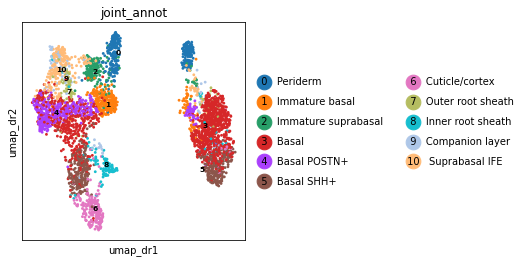

In [113]:
sk.plot_embedding(pooled_KC_ad, basis='umap_dr', groupby='joint_annot');

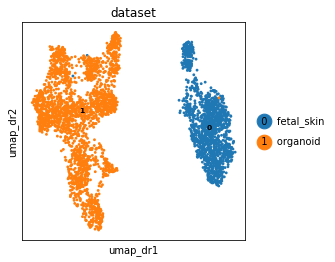

In [ ]:
sk.plot_embedding(pooled_KC_ad, basis='umap_dr', groupby='dataset');

## By cell type

In [12]:
pooled_KC_rss_cellType = regulon_specificity_scores(pooled_KC_auc_mtx, pooled_KC_ad.obs.joint_annotation)

In [121]:
pooled_KC_rss_cellType.iloc[0:5, 0:5]

,AHR_(+),ARID3A_(+),ARNT_(+),ARNTL_(+),ARNTL2_(+)
Periderm,0.293615,0.291074,0.263018,0.270520,0.257897
Immature basal,0.269759,0.265364,0.264342,0.251853,0.241808
Immature suprabasal,0.232707,0.237327,0.219951,0.230846,0.214903
Basal,0.414842,0.394625,0.412376,0.381738,0.364335
Outer root sheath,0.198267,0.203858,0.201639,0.203104,0.207252


In [ ]:
pooled_KC_ad.obs.joint_annot.cat.categories.size

11

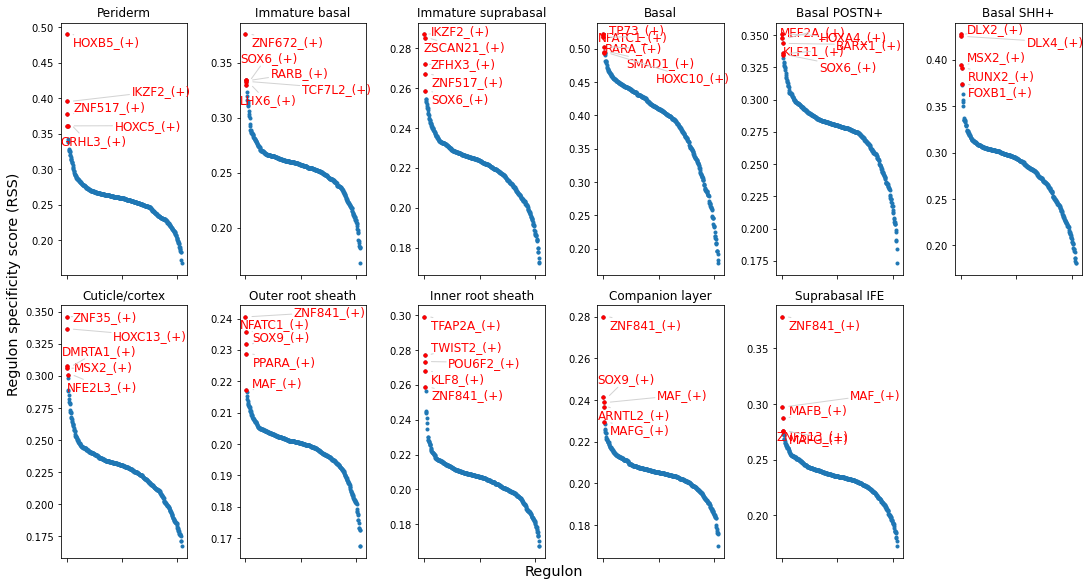

In [138]:
fig = plt.figure(figsize=(15, 8))
for i, c in enumerate(pooled_KC_ad.obs.joint_annot.cat.categories):
    num = i + 1
    x = pooled_KC_rss_cellType.T[c]
    ax = fig.add_subplot(2, 6, num)
    plot_rss(pooled_KC_rss_cellType, c, top_n=5, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )

fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
    'figure.titlesize': 'large' ,
    'axes.labelsize': 'medium',
    'axes.titlesize':'large',
    'xtick.labelsize':'medium',
    'ytick.labelsize':'medium'
})

In [127]:
pooled_KC_topreg = []
for i, c in enumerate(pooled_KC_ad.obs.joint_annot.cat.categories):
    pooled_KC_topreg.extend(
        list(pooled_KC_rss_cellType.T[c].sort_values(ascending=False)[:5].index)
    )
pooled_KC_topreg = list(set(pooled_KC_topreg))

In [139]:
pooled_KC_auc_mtx_Z = pd.DataFrame(index=pooled_KC_auc_mtx.index)
for col in list(pooled_KC_auc_mtx.columns):
    pooled_KC_auc_mtx_Z[ col ] = (pooled_KC_auc_mtx[col] - pooled_KC_auc_mtx[col].mean()) / pooled_KC_auc_mtx[col].std(ddof=0)

In [142]:
colors = sns.color_palette('bright',n_colors=pooled_KC_ad.obs.joint_annot.cat.categories.size)
colorsd = dict(zip(pooled_KC_ad.obs.joint_annot.cat.categories, colors ))
colormap = [colorsd[x] for x in pooled_KC_ad.obs.joint_annot]

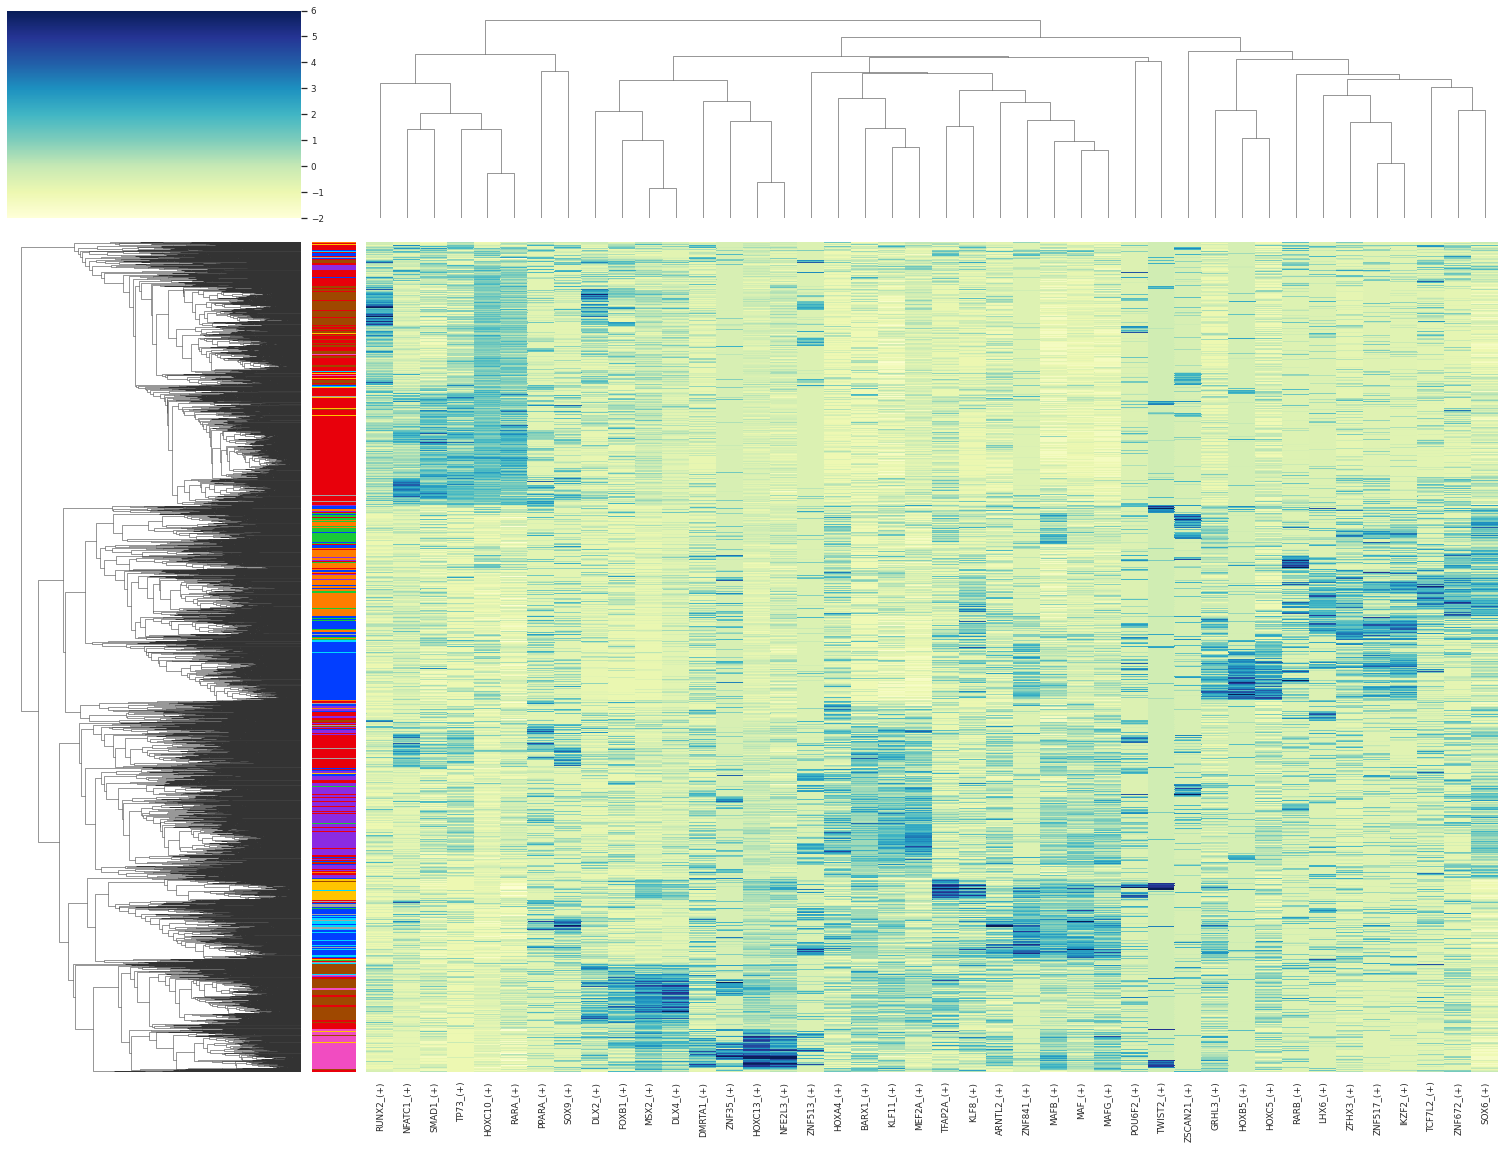

In [199]:
g = sns.clustermap(pooled_KC_auc_mtx_Z[pooled_KC_topreg], square=False, linecolor='gray',
    yticklabels=False, xticklabels=True, vmin=-2, vmax=6, row_colors=colormap, method='average', metric='cosine',
    cmap="YlGnBu", figsize=(21,16));
g.cax.set_visible(True);
g.ax_heatmap.set_ylabel('');
g.ax_heatmap.set_xlabel('');

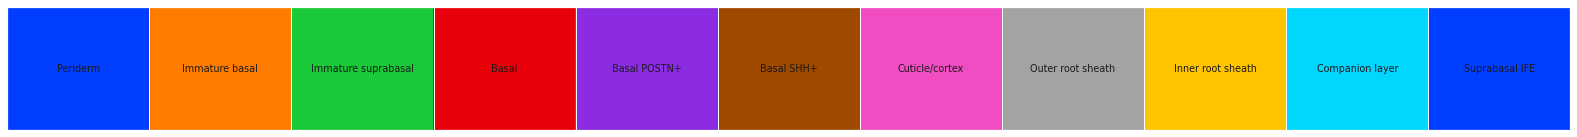

In [168]:
sns.set(font_scale=0.8)
fig = palplot(colors, pooled_KC_ad.obs.joint_annot.cat.categories, size=2)

In [201]:
pooled_KC_binary_mtx, pooled_KC_auc_thresholds = binarize(pooled_KC_auc_mtx, num_workers=5)
pooled_KC_binary_mtx.head()

,AHR_(+),ARID3A_(+),ARNT_(+),ARNTL_(+),ARNTL2_(+),ATF1_(+),ATF2_(+),ATF3_(+),ATF4_(+),ATF5_(+),...,ZNF786_(+),ZNF808_(+),ZNF814_(+),ZNF84_(+),ZNF841_(+),ZNF91_(+),ZNF92_(+),ZNF93_(+),ZSCAN21_(+),ZXDA_(+)
AAAGTAGAGTATCGAA-1-FCAImmP7316888-fetal_skin,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
AACCATGAGATTACCC-1-FCAImmP7316888-fetal_skin,0,1,0,0,0,0,0,0,0,0,...,1,0,0,1,1,0,0,0,0,0
ACCTTTAGTTCCACAA-1-FCAImmP7316888-fetal_skin,1,1,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,1
AGAGTGGTCGAACTGT-1-FCAImmP7316888-fetal_skin,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
AGCGTCGTCAGAGCTT-1-FCAImmP7316888-fetal_skin,0,1,0,0,0,0,0,0,0,0,...,1,0,0,1,1,0,0,0,0,0


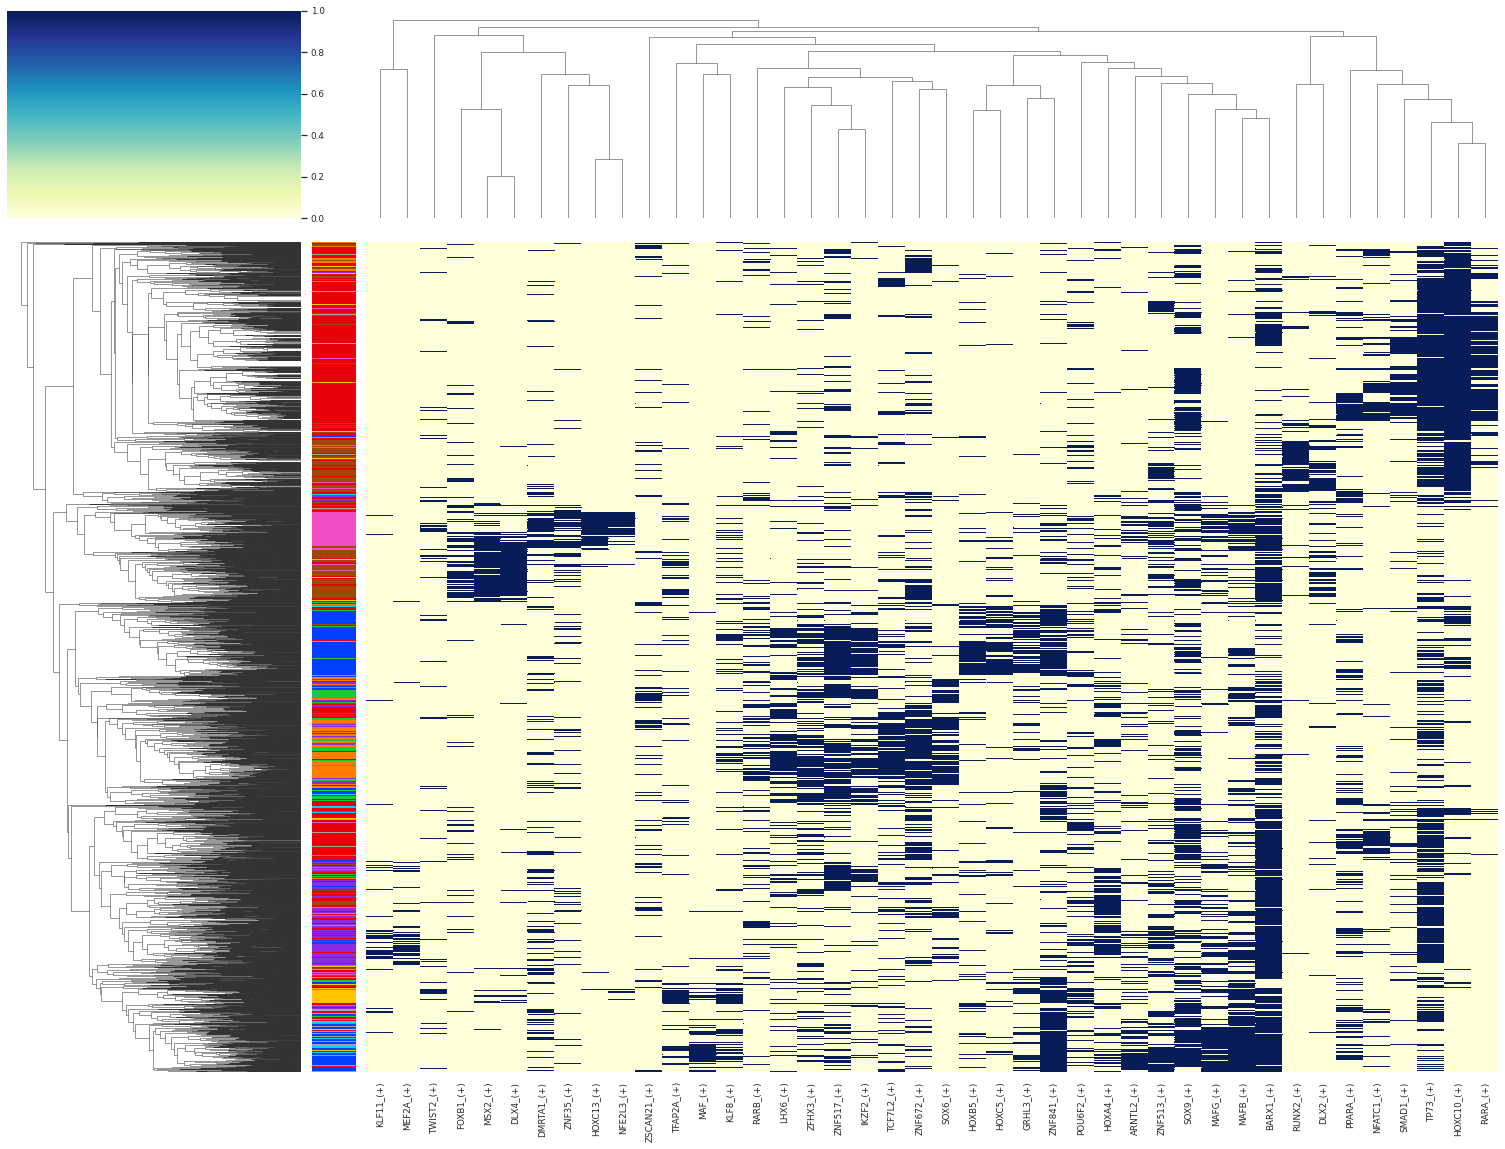

In [213]:
g2 = sns.clustermap(pooled_KC_binary_mtx[pooled_KC_topreg], square=False, linecolor='gray',
    yticklabels=False, xticklabels=True, vmin=0, vmax=1, row_colors=colormap, method='average', metric='cosine',
    cmap="YlGnBu", figsize=(21,16));
g.cax.set_visible(True);
g.ax_heatmap.set_ylabel('');
g.ax_heatmap.set_xlabel('');

## By data source

In [14]:
pooled_KC_rss_dataset = regulon_specificity_scores(pooled_KC_auc_mtx, pooled_KC_ad.obs.dataset)

In [15]:
pooled_KC_rss_dataset.iloc[0:5, 0:5]

,AHR(+),ARID3A(+),ARNT(+),ARNTL(+),ARNTL2(+)
fetal_skin,0.455123,0.415624,0.45054,0.404381,0.362018
organoid,0.552676,0.647926,0.57436,0.635256,0.592080


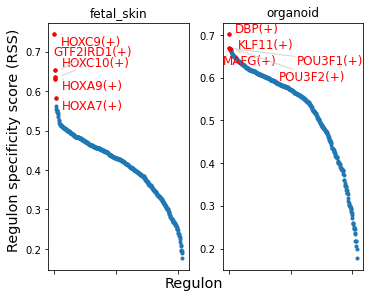

In [31]:
fig = plt.figure(figsize=(5, 4))
for i, c in enumerate(pooled_KC_ad.obs.dataset.cat.categories):
    num = i + 1
    x = pooled_KC_rss_dataset.T[c]
    ax = fig.add_subplot(1, 2, num)
    plot_rss(pooled_KC_rss_dataset, c, top_n=5, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )

fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
    'figure.titlesize': 'large' ,
    'axes.labelsize': 'medium',
    'axes.titlesize':'large',
    'xtick.labelsize':'medium',
    'ytick.labelsize':'medium'
})

In [17]:
pooled_KC_top5reg = []
for i, c in enumerate(pooled_KC_ad.obs.dataset.cat.categories):
    pooled_KC_top5reg.extend(
        list(pooled_KC_rss_dataset.T[c].sort_values(ascending=False)[:5].index)
    )
pooled_KC_top5reg = list(set(pooled_KC_top5reg))

In [18]:
pooled_KC_top20reg = []
for i, c in enumerate(pooled_KC_ad.obs.dataset.cat.categories):
    pooled_KC_top20reg.extend(
        list(pooled_KC_rss_dataset.T[c].sort_values(ascending=False)[:20].index)
    )
pooled_KC_top20reg = list(set(pooled_KC_top20reg))

In [19]:
pooled_KC_auc_mtx_Z = pd.DataFrame(index=pooled_KC_auc_mtx.index)
for col in list(pooled_KC_auc_mtx.columns):
    pooled_KC_auc_mtx_Z[ col ] = (pooled_KC_auc_mtx[col] - pooled_KC_auc_mtx[col].mean()) / pooled_KC_auc_mtx[col].std(ddof=0)

In [20]:
colors = sns.color_palette('bright',n_colors=pooled_KC_ad.obs.dataset.cat.categories.size)
colorsd = dict(zip(pooled_KC_ad.obs.dataset.cat.categories, colors ))
colormap = [colorsd[x] for x in pooled_KC_ad.obs.dataset]

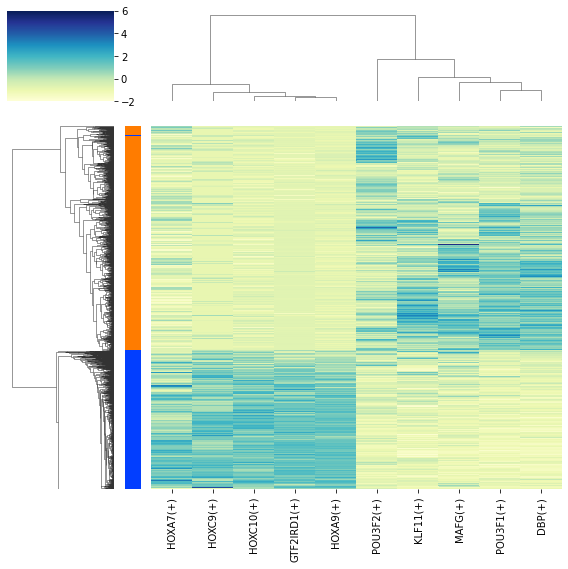

In [40]:
g = sns.clustermap(pooled_KC_auc_mtx_Z[pooled_KC_top5reg], square=False, linecolor='gray',
    yticklabels=False, xticklabels=True, vmin=-2, vmax=6, row_colors=colormap, method='average', metric='cosine',
    cmap="YlGnBu", figsize=(8,8));
g.cax.set_visible(True);
g.ax_heatmap.set_ylabel('');
g.ax_heatmap.set_xlabel('');

/home/ubuntu/miniconda/envs/pyscenic/lib/python3.8/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


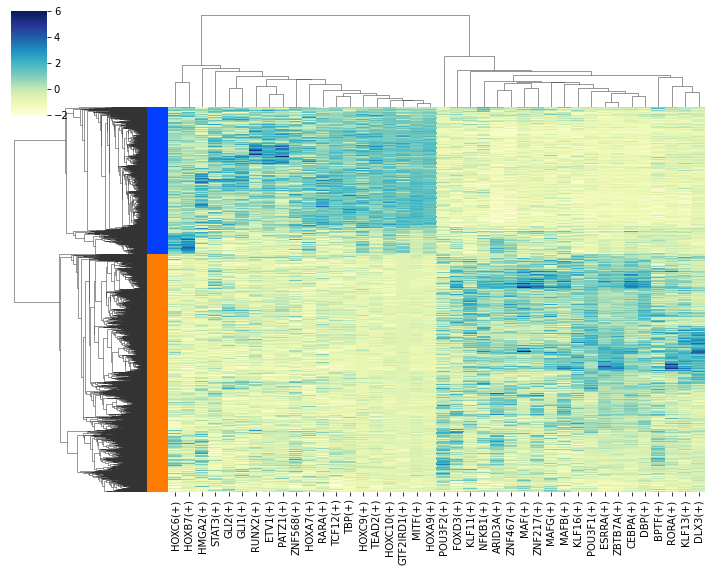

In [37]:
g = sns.clustermap(pooled_KC_auc_mtx_Z[pooled_KC_top20reg], square=False, linecolor='gray',
    yticklabels=False, xticklabels=True, vmin=-2, vmax=6, row_colors=colormap, method='average', metric='cosine',
    cmap="YlGnBu", figsize=(10, 8));
g.cax.set_visible(True);
g.ax_heatmap.set_ylabel('');
g.ax_heatmap.set_xlabel('');

In [38]:
for gene in np.array(pooled_KC_top20reg)[np.array(g.dendrogram_col.dendrogram['leaves'][0:20])]:
    print(gene[0:-3])

HOXC6
HOXB7
HMGA2
STAT3
GLI2
GLI1
RUNX2
ETV1
PATZ1
ZNF568
HOXA7
RARA
TCF12
TBP
HOXC9
TEAD2
HOXC10
GTF2IRD1
MITF
HOXA9


In [39]:
for gene in np.array(pooled_KC_top20reg)[np.array(g.dendrogram_col.dendrogram['leaves'][-20:])]:
    print(gene[0:-3])

POU3F2
FOXD3
KLF11
NFKB1
ARID3A
ZNF467
MAF
ZNF217
MAFG
MAFB
KLF16
POU3F1
ESRRA
ZBTB7A
CEBPA
DBP
BPTF
RORA
KLF13
DLX3


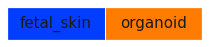

In [52]:
sns.set(font_scale=0.8)
fig = palplot(colors, pooled_KC_ad.obs.dataset.cat.categories, size=1.5)

In [201]:
pooled_KC_binary_mtx, pooled_KC_auc_thresholds = binarize(pooled_KC_auc_mtx, num_workers=5)
pooled_KC_binary_mtx.head()

,AHR_(+),ARID3A_(+),ARNT_(+),ARNTL_(+),ARNTL2_(+),ATF1_(+),ATF2_(+),ATF3_(+),ATF4_(+),ATF5_(+),...,ZNF786_(+),ZNF808_(+),ZNF814_(+),ZNF84_(+),ZNF841_(+),ZNF91_(+),ZNF92_(+),ZNF93_(+),ZSCAN21_(+),ZXDA_(+)
AAAGTAGAGTATCGAA-1-FCAImmP7316888-fetal_skin,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
AACCATGAGATTACCC-1-FCAImmP7316888-fetal_skin,0,1,0,0,0,0,0,0,0,0,...,1,0,0,1,1,0,0,0,0,0
ACCTTTAGTTCCACAA-1-FCAImmP7316888-fetal_skin,1,1,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,1
AGAGTGGTCGAACTGT-1-FCAImmP7316888-fetal_skin,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
AGCGTCGTCAGAGCTT-1-FCAImmP7316888-fetal_skin,0,1,0,0,0,0,0,0,0,0,...,1,0,0,1,1,0,0,0,0,0


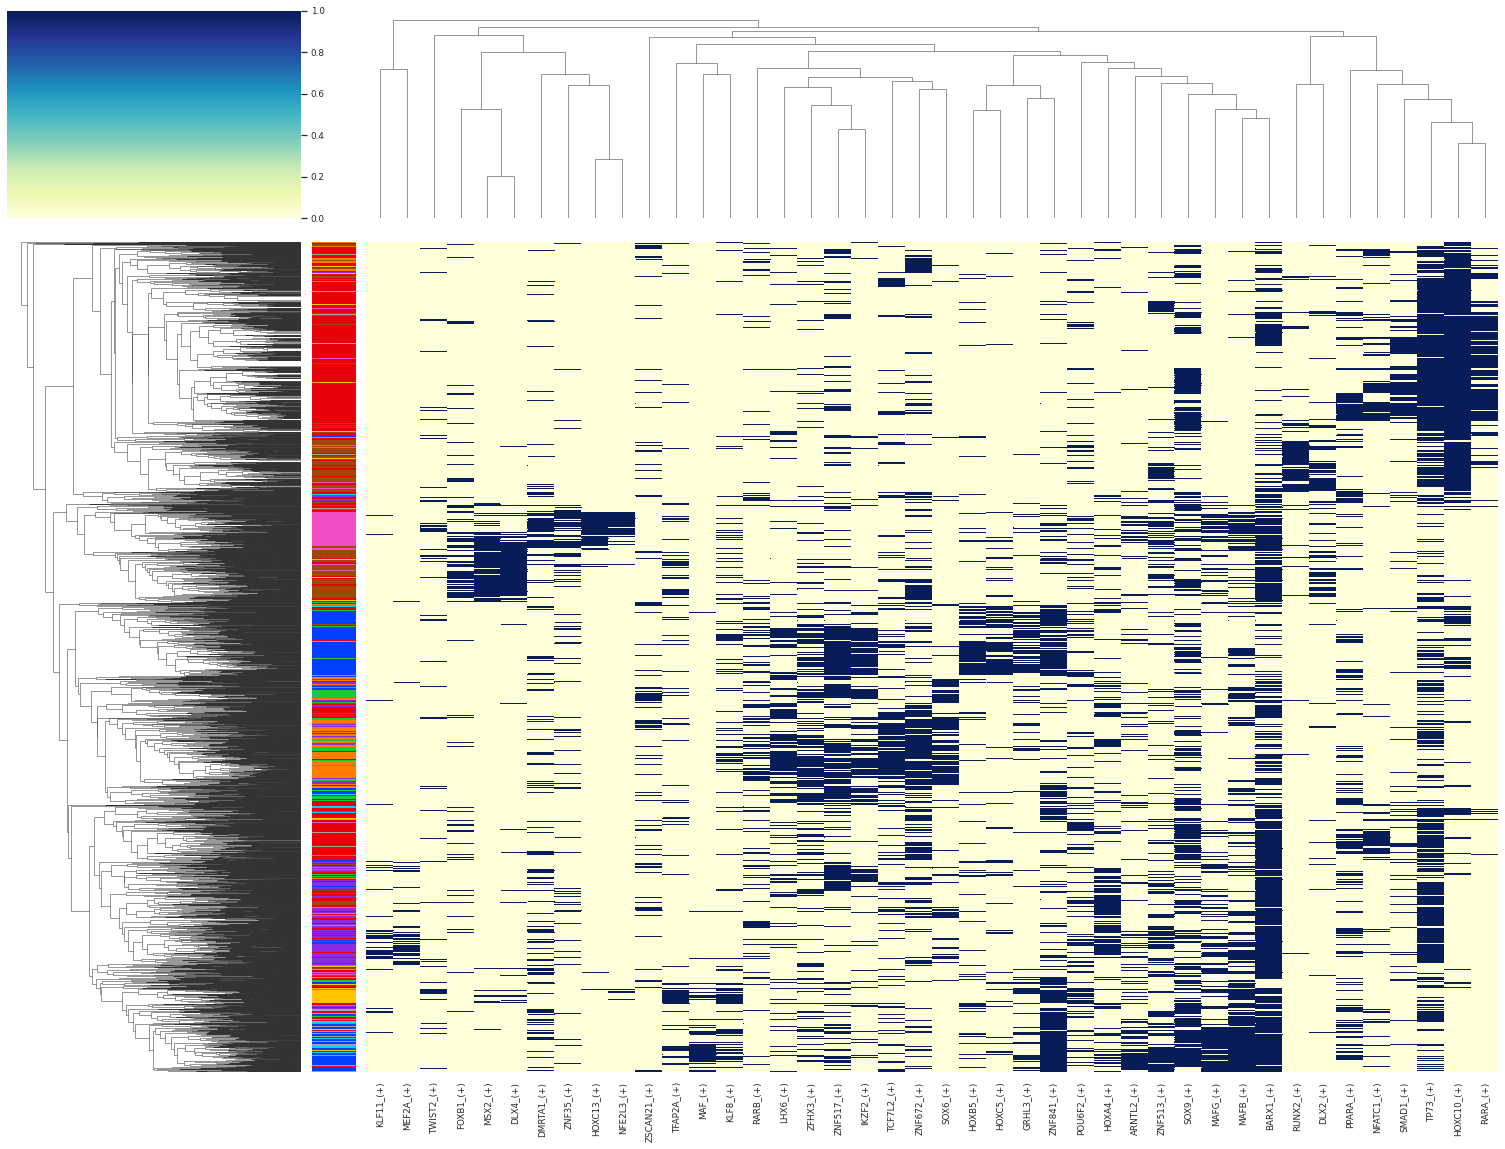

In [213]:
g2 = sns.clustermap(pooled_KC_binary_mtx[pooled_KC_top5reg], square=False, linecolor='gray',
    yticklabels=False, xticklabels=True, vmin=0, vmax=1, row_colors=colormap, method='average', metric='cosine',
    cmap="YlGnBu", figsize=(21,16));
g.cax.set_visible(True);
g.ax_heatmap.set_ylabel('');
g.ax_heatmap.set_xlabel('');